In [2]:
import xgboost
import numpy as np

>actual=67.0, predicted=49.7
>actual=68.0, predicted=60.5
>actual=62.0, predicted=77.1
>actual=37.0, predicted=64.9
>actual=37.0, predicted=40.4
>actual=52.0, predicted=41.6
>actual=56.0, predicted=45.2
>actual=50.0, predicted=52.0
>actual=35.0, predicted=53.4
>actual=23.0, predicted=43.0
>actual=25.0, predicted=27.4
>actual=44.0, predicted=35.2
>actual=25.0, predicted=45.3
>actual=23.0, predicted=38.1
>actual=24.0, predicted=36.2
>actual=21.0, predicted=23.3
>actual=32.0, predicted=21.9
>actual=31.0, predicted=25.9
>actual=37.0, predicted=28.5
MSE: 179.748
RMSE: 13.407


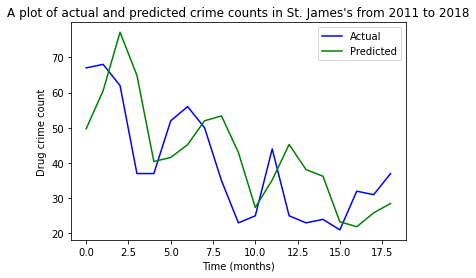

In [3]:
# forecast monthly crime counts with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=500, colsample_bylevel=0.4,
                         learning_rate=0.15, max_depth=7, random_state=0)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat_j = model.predict(asarray([testX]))
    return yhat_j[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat_j = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat_j)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>actual=%.1f, predicted=%.1f' % (testy, yhat_j))
    # estimate prediction error
    error = mean_squared_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

# load the dataset
series = read_csv('st_james.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mse, y, yhat_j = walk_forward_validation(data, 19)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % float(format(np.sqrt(mse))))
# plot expected vs preducted
pyplot.plot(y, color='blue', label='Actual')
pyplot.plot(yhat_j, color='green', label='Predicted')
pyplot.rcParams['figure.figsize']=[10, 3]
pyplot.xlabel('Time (months)')
pyplot.ylabel('Drug crime count')
pyplot.legend()
pyplot.title("A plot of actual and predicted crime counts in St. James's from 2011 to 2018")
pyplot.show()

In [4]:
st_james_df = read_csv('st_james.csv')
st_james_df['count_pred'] = 0
st_james_df['count_pred'][77:] = yhat_j
st_james_df.tail()

,Year,count,count_pred
91,201808,24,36.239769
92,201809,21,23.311880
93,201810,32,21.906151
94,201811,31,25.850086
95,201812,37,28.515831


Text(0.5, 1.0, "Actual and predicted crime count in St. James's from 2011 to 2018")

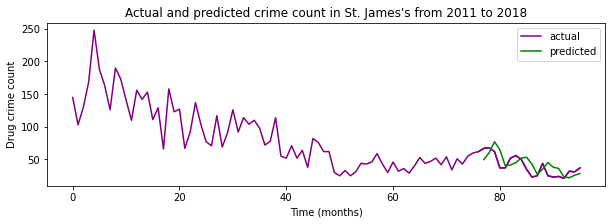

In [5]:
pyplot.plot(st_james_df['count'], color='purple')
pyplot.plot(st_james_df['count'][76:], color='purple', label='actual')
pyplot.plot(st_james_df['count_pred'][77:], color='green', label='predicted')
pyplot.legend()
pyplot.xlabel('Time (months)')
pyplot.ylabel('Drug crime count')
pyplot.title("Actual and predicted crime count in St. James's from 2011 to 2018")

-----------------------------------------------------------------------------------------------------------------